In [336]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import cvxpy as cp

def barycentric_distance(x, y, N):
    # mean squared deviation from the classical barycenter of the xi
    #rescale x and y to be in [0,1]
    x = x / N
    y = y / N
    barycenter = x * 0.5 + y * 0.5
    barycenter = 0.5 * np.sum((x - barycenter) ** 2, axis=0) + 0.5 * np.sum(
        (y - barycenter) ** 2, axis=0)

    return barycenter

def get_cost(N,child):
    #rewrite unravel_index without numpy
    i = np.array([child.transpose()[0] // N, child.transpose()[0] % N])
    j = np.array([child.transpose()[1] // N, child.transpose()[1] % N])
    return barycentric_distance(i,j, N)

def compute_gain_numba(current_kantorovich_u, current_kantorovich_v, cost, children):
    return current_kantorovich_u[children.transpose()[0]] + current_kantorovich_v[children.transpose()[1]] - cost

def find_best_child(parent, half_child,current_kantorovich_u, current_kantorovich_v, N):
    parent_2 = parent.copy()
    print("#######")
    print(parent.shape)
    print(parent)
    parent[1] = np.random.randint(0, N**2, size=len(parent[1]))
    children = parent.transpose()
    gain = compute_gain_numba(current_kantorovich_u, current_kantorovich_v, get_cost(N, children), children)
    best_gain = np.max(gain)
    best_child = children[np.argmax(gain)]
    if best_gain > 0:
        return best_gain, best_child
    else:
        parent_2[0] = np.random.randint(0, N**2, size=len(parent[1]))
        children = parent_2.transpose()
        gain = compute_gain_numba(current_kantorovich_u, current_kantorovich_v, get_cost(N, children), children)
        best_gain = np.max(gain)
        best_child = children[np.argmax(gain)]

    return best_gain, best_child


class Genetic_Algorithm:
    def __init__(self, beta, img1, img2):
        
        self.beta = beta
        self.N = img1.shape[0]
        self.M = img2.shape[0]
        self.img1 = img1.flatten()
        self.img2 = img2.flatten()
        self.b_eq = np.concatenate((self.img1, self.img2))
        
        start = time.time()
        print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost()
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
        start = time.time()
        print("initializing full model...")
        self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
        print("full model initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        
    def initialize_model(self):
        indices_row = np.array([])
        indices_col = np.array([])

        for indices in range(self.N**2):
            gamma_indices = np.where(self.active_indices.transpose()[0] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*indices))

        for indices in range(self.M**2):
            gamma_indices = np.where(self.active_indices.transpose()[1] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+self.N**2)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**2 + self.M**2, len(self.active_indices)))
        gamma = cp.Variable(len(self.current_cost_vector))
        objective = cp.Minimize(self.current_cost_vector @ gamma)
        constraints = [A_eq @ gamma == self.b_eq, gamma >= 0]
        prob = cp.Problem(objective, constraints)
        gamma.value = self.current_gamma
        prob.solve(warm_start = True, solver=cp.GUROBI)
        primal_solution = gamma.value
        dual_solution = -constraints[0].dual_value
        return primal_solution, A_eq, dual_solution[:self.N**2], dual_solution[self.N**2:]




    def barycentric_distance(self,x, y):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        x = x / self.N
        y = y / self.M
        barycenter = x * 0.5 + y * 0.5
        barycenter = 0.5 * np.sum((x - barycenter) ** 2) + 0.5 * np.sum(
            (y - barycenter) ** 2)
        return barycenter

    def get_cost(self):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_img1 = np.array(np.unravel_index(self.active_indices.transpose()[0], (self.N, self.N)))
        indices_img2 = np.array(np.unravel_index(self.active_indices.transpose()[1], (self.M, self.M)))
        cost_vector = barycentric_distance(indices_img1, indices_img2, self.N)
        return cost_vector
    
    def get_single_cost(self, child):
        i = np.array(np.unravel_index(child[0], (self.N, self.N)))
        j = np.array(np.unravel_index(child[1], (self.M, self.M)))
        return self.barycentric_distance(i,j)

    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        omega = [[0,0]]
        i, j = 0, 0
        b = np.array([self.img1[0], self.img2[0]])
        gamma = []
        current_gamma = [min(b[0], b[1])]
        while i < self.N**2-1 and j < self.M**2-1:
            gamma = min(b[0], b[1])
            b = b - gamma
            if np.argmin(b) == 0:
                i += 1
                b[0] += self.img1[i]
                omega.append([i, j])
                current_gamma.append(gamma)
            else:
                j += 1
                b[1] += self.img2[j]
                omega.append([i, j])
                current_gamma.append(gamma)
        while i < self.N**2-1:
            i += 1
            omega.append([i, j])
            current_gamma.append(0)
        while j < self.M**2-1:
            j += 1
            omega.append([i, j])
            current_gamma.append(0)


        return np.array(current_gamma), np.array(omega)
    
    def run(self, max_iter, chunk_size):
        for _ in tqdm(range(max_iter)):


            best_gain = -1
            best_child = None

            start = time.time()
            non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            generator = itertools.product(np.arange(self.N**2), non_zero_indices)
            sample = 0

            while True:
                #slice the generator into chunks of size chunk_size and get separately the non zero indices and the index

                chunk = list(itertools.islice(generator, chunk_size))
                if not chunk:
                    break

                # get the first element for each element of the chunk
                half_child, parent = np.array(chunk).transpose()

                #transform the list of arrays into an array of arrays
                parent = np.array(parent.tolist()).transpose()
                best_gain, best_child = find_best_child(parent, half_child, self.current_kantorovich_u, self.current_kantorovich_v, self.N)

                if best_gain > 0:
                    break
                sample += chunk_size

            if best_gain<=0:
                break
           
            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)
            self.active_indices = np.vstack((self.active_indices, best_child))
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_single_cost(best_child))
            self.current_gamma = np.append(self.current_gamma, 0)
            if self.active_indices.shape[0] > self.beta*(self.N**2 + self.M**2):
                #delete first (beta-1)*(N^2 + M^2) 0 entries
                zero_indices = np.where(self.current_gamma == 0)[:beta]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP, self.current_kantorovich_u, self.current_kantorovich_v = self.initialize_model()
                continue
            self.solve_model()



    def compute_gain(self, child):
        return self.current_kantorovich_u[child[0]] + self.current_kantorovich_v[child[1]] - self.get_single_cost(child)


    def solve_model(self):
        start = time.time()

        A_eq = self.constraints_RMP

        #add a column to A_eq that has a 1 in the coordinate corresponding to the new  child

        child_mu, child_nu = self.active_indices[-1]

        A_col = np.zeros(self.N**2 + self.M**2)
        A_col[child_mu] = 1
        A_col[self.N**2 + child_nu] = 1


        #add the column horizontally
        A_eq = sp.hstack((A_eq, A_col.reshape(-1,1)))

        self.constraints_RMP = A_eq
        gamma = cp.Variable(len(self.current_cost_vector))
        prob = cp.Problem(cp.Minimize(self.current_cost_vector @ gamma), [A_eq @ gamma == self.b_eq, gamma >= 0])
        gamma.value = self.current_gamma

        prob.solve(warm_start=True, solver=cp.GUROBI)

        primal_solution = gamma.value
        dual_solution = -prob.constraints[0].dual_value
        self.cost.append(prob.value)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich_u = dual_solution[:self.N**2]
        self.current_kantorovich_v = dual_solution[self.N**2:]

    def get_mean(self, par):
        indices_x = np.unravel_index(self.active_indices.transpose()[0], (img1.shape[0], img1.shape[0]))
        indices_y = np.unravel_index(self.active_indices.transpose()[1], (img2.shape[0], img2.shape[0]))
        mean = (par * indices_x[0] + (1 - par) * indices_y[0]).astype('int'), (
                    par * indices_x[1] + (1 - par) * indices_y[1]).astype('int')
        #transform the mean back to a 1d index
        mean = np.ravel_multi_index(mean, (img1.shape[0], img1.shape[0]))
        #check how many coordinates of mean and indices_x are the same
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(img1.shape[0] ** 2, img2.shape[0] ** 2))
        return gamma.todense().transpose().dot(normalized_img1.flatten()).reshape(img1.shape[0], img1.shape[0])

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        plt.close()
        fig, axs = plt.subplots(2, 6)
        axs[0][0].imshow(self.get_mean(1), cmap='gray')
        axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
        axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
        axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
        axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
        axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
        axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
        axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
        axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
        axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
        axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
        axs[1][5].imshow(self.get_mean(0), cmap='gray')
        plt.show()
 

In [337]:
if __name__ == '__main__':
    lambda_parameter = 0.5
    #generate values between 0 and 1
    #load images
    path_img1 = "dog.jpg"
    path_img2 = "cat.jpg"
    img1 = np.array(Image.open(path_img1).convert('L'))
    #switch black and white
    img2 = np.array(Image.open(path_img2).convert('L'))
    img_coordinates = np.array([[(i, j) for i in range(img1.shape[0])] for j in range(img2.shape[0])])

    img_coordinates = img_coordinates.reshape(img1.shape[0]*img2.shape[0], 2)
    normalized_img1 = img1 / 255
    normalized_img2 = img2 / 255
    normalized_img1 = 1 - normalized_img1
    normalized_img2 = 1 - normalized_img2
    normalized_img1 = (normalized_img1 / np.sum(normalized_img1))*img1.shape[0]
    normalized_img2 = (normalized_img2 / np.sum(normalized_img2))*img2.shape[0]
    beta = 3  # hyperparameter
    ga = Genetic_Algorithm(beta=beta, img1=normalized_img1, img2=normalized_img2)

initializing omega...
omega initialized in 0.005. s
initializing cost vector...
cost vector initialized in 0.000. s
initializing full model...
full model initialized in 0.021. s


In [338]:
ga.run(max_iter=1000, chunk_size=10000)
ga.reduce()

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/kl/7vjjry6d5gjg6tbv6l5w90nm0000gn/T/ipykernel_38769/3430493420.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  half_child, parent = np.array(chunk).transpose()
  0%|          | 4/1000 [00:00<00:26, 38.05it/s]

#######
(2, 10000)
[[  5   6   6 ... 198 198 198]
 [  0   0   5 ... 211 212 213]]
#######
(2, 10000)
[[  5   6   6 ... 198 198 199]
 [  0   0   5 ... 212 213 213]]
#######
(2, 10000)
[[  5   6   6 ... 198 198 199]
 [  0   0   5 ... 212 213 213]]
#######
(2, 10000)
[[  5   6   6 ... 198 198 199]
 [  0   0   5 ... 212 213 213]]
#######
(2, 10000)
[[  5   6   6 ... 198 198 199]
 [  0   0   5 ... 212 213 213]]
#######
(2, 10000)
[[  5   6   6 ... 198 199 199]
 [  0   0   5 ... 213 213 215]]
#######
(2, 10000)
[[  5   6   6 ... 198 199 199]
 [  0   0   5 ... 213 213 215]]
#######
(2, 10000)
[[  5   6   6 ... 198 199 199]
 [  0   0   5 ... 213 213 215]]


  1%|▏         | 13/1000 [00:00<00:30, 32.84it/s]

#######
(2, 10000)
[[  5   6   6 ... 198 199 199]
 [  0   0   5 ... 213 213 215]]
#######
(2, 10000)
[[  5   6   6 ... 199 199 199]
 [  0   0   5 ... 213 215 216]]
#######
(2, 10000)
[[  5   6   6 ... 199 199 200]
 [  0   0   5 ... 215 216 216]]
#######
(2, 10000)
[[  5   6   6 ... 199 199 200]
 [  0   0   5 ... 215 216 216]]
#######
(2, 10000)
[[  5   6   6 ... 199 200 200]
 [  0   0   5 ... 216 216 217]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 216 217 218]]


  2%|▏         | 17/1000 [00:00<00:32, 30.03it/s]

#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 216 217 218]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 216 217 218]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 217 218 219]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 217 218 219]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 217 218 219]]


  2%|▏         | 24/1000 [00:00<00:37, 25.75it/s]

#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 217 218 219]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 200]
 [  0   5   5 ... 218 219 220]]
#######
(2, 10000)
[[  5   6   9 ... 200 200 201]
 [  0   5   5 ... 219 220 220]]
#######
(2, 10000)
[[  5   6   9 ... 200 201 201]
 [  0   5   5 ... 220 220 221]]
#######
(2, 10000)
[[  5   6   9 ... 200 201 201]
 [  0   5   5 ... 220 220 221]]


  3%|▎         | 28/1000 [00:00<00:34, 28.49it/s]

#######
(2, 10000)
[[  5   6   9 ... 201 201 201]
 [  0   5   5 ... 220 221 222]]
#######
(2, 10000)
[[  5   6   9 ... 201 201 201]
 [  0   5   5 ... 220 221 222]]
#######
(2, 10000)
[[  5   6   9 ... 201 201 202]
 [  0   5   5 ... 221 222 222]]
#######
(2, 10000)
[[  5   6   6 ... 201 201 201]
 [  0   0   5 ... 220 221 222]]
#######
(2, 10000)
[[  5   6   6 ... 201 201 201]
 [  0   0   5 ... 220 221 222]]
#######
(2, 10000)
[[  5   6   6 ... 201 201 201]
 [  0   0   5 ... 220 221 222]]
#######
(2, 10000)
[[  5   6   9 ... 201 202 202]
 [  0   5   5 ... 222 222 223]]
#######
(2, 10000)
[[  5   6   6 ... 201 202 202]
 [  0   0   5 ... 222 222 223]]
#######
(2, 10000)
[[  5   6   9 ... 201 202 202]
 [  0   5   5 ... 222 222 223]]


  4%|▍         | 38/1000 [00:01<00:26, 35.86it/s]

#######
(2, 10000)
[[  5   6   9 ... 202 202 202]
 [  0   5   5 ... 223 225 227]]
#######
(2, 10000)
[[  5   6   9 ... 202 202 202]
 [  0   5   5 ... 223 225 227]]
#######
(2, 10000)
[[  5   6   9 ... 202 202 202]
 [  0   5   5 ... 225 227 228]]
#######
(2, 10000)
[[  5   6   6 ... 202 202 202]
 [  0   0   5 ... 227 228 229]]
#######
(2, 10000)
[[  5   6   6 ... 202 202 202]
 [  0   0   5 ... 227 228 229]]
#######
(2, 10000)
[[  5   6   6 ... 202 202 202]
 [  0   0   5 ... 227 228 229]]
#######
(2, 10000)
[[  5   6   6 ... 202 202 202]
 [  0   0   5 ... 227 228 229]]
#######
(2, 10000)
[[  5   6   6 ... 202 202 202]
 [  0   0   5 ... 227 228 229]]
#######
(2, 10000)
[[  5   6   9 ... 202 202 203]
 [  0   5   5 ... 228 229 229]]


  5%|▍         | 48/1000 [00:01<00:23, 40.05it/s]

#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 229 230 231]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 229 230 231]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 229 230 231]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   6 ... 203 203 203]
 [  0   0   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   6 ... 203 203 203]
 [  0   0   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]


  6%|▌         | 58/1000 [00:01<00:22, 41.04it/s]

#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 203]
 [  0   5   5 ... 230 231 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 204]
 [  0   5   5 ... 231 232 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 204]
 [  0   5   5 ... 231 232 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 204]
 [  0   5   5 ... 231 232 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 203 204]
 [  0   5   5 ... 231 232 232]]
#######
(2, 10000)
[[  5   6   9 ... 203 204 204]
 [  0   5   5 ... 232 232 233]]
#######
(2, 10000)
[[  5   6   9 ... 203 204 204]
 [  0   5   5 ... 232 232 233]]
#######
(2, 10000)
[[  5   6   9 ... 203 204 204]
 [  0   5   5 ... 232 232 233]]


  7%|▋         | 68/1000 [00:01<00:21, 42.47it/s]

#######
(2, 10000)
[[  5   6   9 ... 204 204 204]
 [  0   5   5 ... 232 233 234]]
#######
(2, 10000)
[[  5   6   9 ... 204 204 204]
 [  0   5   5 ... 232 233 234]]
#######
(2, 10000)
[[  5   6   9 ... 204 204 204]
 [  0   5   5 ... 232 233 234]]
#######
(2, 10000)
[[  5   6   9 ... 204 204 205]
 [  0   5   5 ... 233 234 234]]
#######
(2, 10000)
[[  5   6   9 ... 204 204 205]
 [  0   5   5 ... 233 234 234]]
#######
(2, 10000)
[[  5   6   9 ... 204 205 205]
 [  0   5   5 ... 234 234 235]]
#######
(2, 10000)
[[  5   6   6 ... 205 205 205]
 [  0   0   5 ... 234 235 236]]
#######
(2, 10000)
[[  5   6   6 ... 205 205 205]
 [  0   0   5 ... 234 235 236]]
#######
(2, 10000)
[[  5   6   6 ... 205 205 206]
 [  0   0   5 ... 235 236 236]]


  8%|▊         | 78/1000 [00:02<00:21, 42.25it/s]

#######
(2, 10000)
[[  5   6   6 ... 205 206 206]
 [  0   0   5 ... 236 236 246]]
#######
(2, 10000)
[[  5   6   6 ... 206 206 206]
 [  0   0   5 ... 236 246 247]]
#######
(2, 10000)
[[  5   6   6 ... 206 206 206]
 [  0   0   5 ... 236 246 247]]
#######
(2, 10000)
[[  5   6   6 ... 206 206 206]
 [  0   0   5 ... 246 247 248]]
#######
(2, 10000)
[[  5   6   6 ... 206 206 207]
 [  0   0   5 ... 247 248 248]]
#######
(2, 10000)
[[  5   6   6 ... 206 207 207]
 [  0   0   5 ... 248 248 249]]
#######
(2, 10000)
[[  5   6   6 ... 206 207 207]
 [  0   0   5 ... 248 248 249]]
#######
(2, 10000)
[[  5   6   9 ... 206 206 206]
 [  0   5   5 ... 243 246 247]]
#######
(2, 10000)
[[  5   6   9 ... 207 207 207]
 [  0   5   5 ... 248 249 250]]


  8%|▊         | 81/1000 [00:02<00:24, 37.09it/s]


#######
(2, 10000)
[[  5   6   9 ... 211 212 213]
 [  0   5   5 ... 250 250 250]]
#######
(2, 10000)
[[  5   6   9 ... 211 212 213]
 [  0   5   5 ... 250 250 250]]


KeyboardInterrupt: 

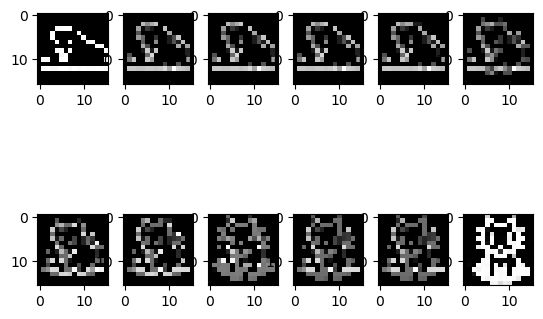

In [334]:
ga.plot()

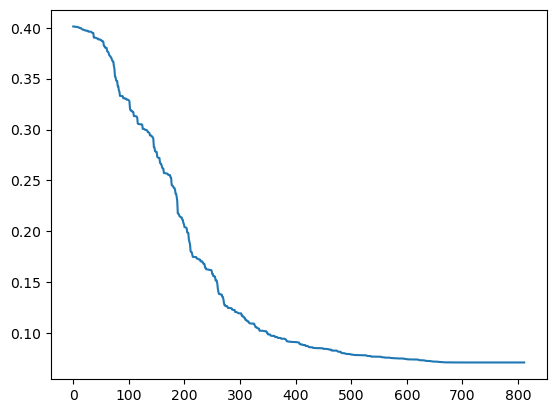

In [335]:
plt.plot(ga.cost)

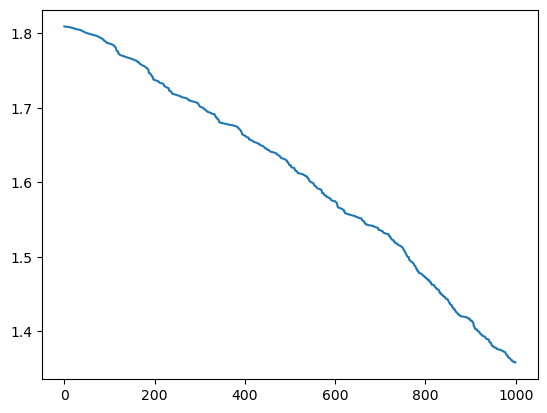

In [263]:
plt.plot(ga.cost)

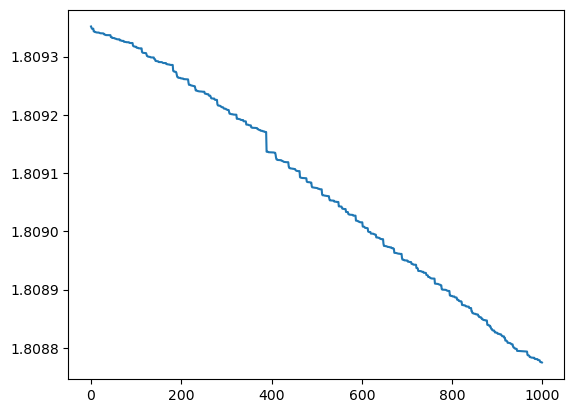

In [249]:
plt.plot(ga.cost)

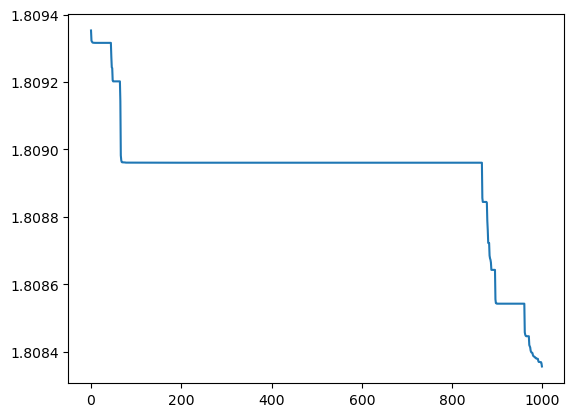

In [241]:
plt.plot(ga.cost)

In [242]:
ga.cost

[1.8093532437717945,
 1.8093228433193624,
 1.809320415104432,
 1.8093180037261227,
 1.8093170890730215,
 1.809317036692422,
 1.8093167224088258,
 1.8093165652670273,
 1.8093165446889348,
 1.8093164773424497,
 1.8093164773424497,
 1.8093164773424497,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.80931647734245,
 1.809275054495413,
 1.809243873302196,
 1.8092413172033965,
 1.8092050845504954,
 1.8092022003294723,
 1.8092022003294723,

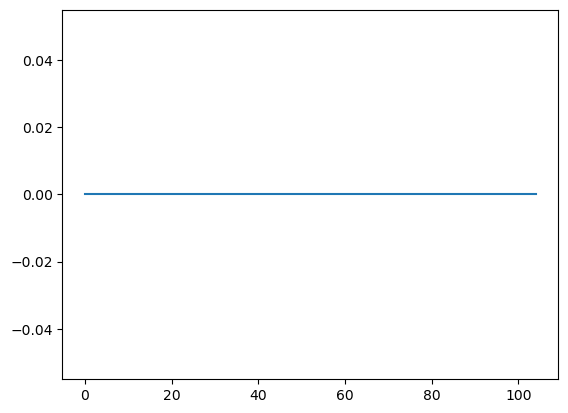

In [327]:
plt.plot(ga.children_sampled)

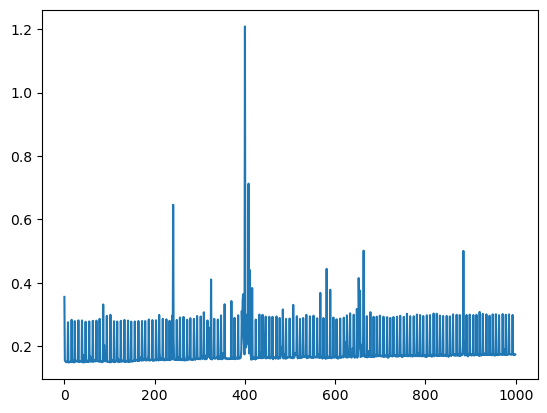

In [302]:
plt.plot(ga.time_model)

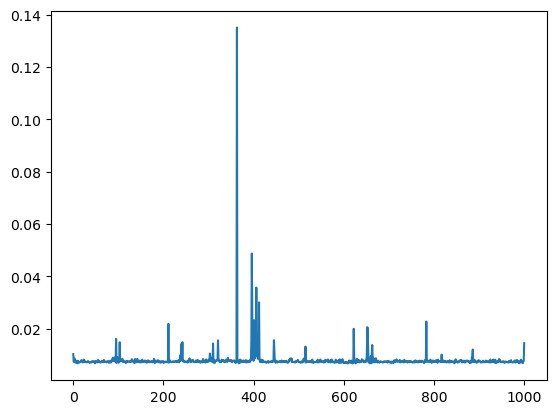

In [303]:
plt.plot(ga.time_child)